# Run 2.1 with just CO2, CH4, N2O for now

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.forcing.ghg import meinshausen2020

from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as pl

In [2]:
erf_2co2 = meinshausen2020(
    np.array([554.30, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array([277.15, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array((1.05, 0.86, 1.07)) * np.ones((1, 1, 1, 1)),
    np.ones((1, 1, 1, 3)),
    np.array([True, False, False]),
    np.array([False, True, False]),
    np.array([False, False, True]),
    np.array([False, False, False])
).squeeze()[0]
erf_2co2

3.9334694485974606

In [3]:
n_scen = 100  # 10000 in full run

In [4]:
f = FAIR()

In [5]:
df_configs = pd.read_csv('../data_input/ar6_calibration_ebm3.csv', index_col=0)

In [6]:
configs = list(df_configs.index)

In [7]:
f.define_time(1750, 2301, 1)
scenarios = list(range(1, n_scen+1))
f.define_scenarios(scenarios)
f.define_configs(configs)

In [8]:
species = ['CO2', 'CH4', 'N2O']
properties = {
    'CO2': {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'CH4': {
        'type': 'ch4',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,  # since there's nothing else defined in the scenario for CH4 to affect
    },
    'N2O': {
        'type': 'n2o',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,  # since there's nothing else defined in the scenario for N2O to affect
    }
}

In [9]:
f.define_species(species, properties)

In [10]:
f.allocate()

In [11]:
species = {}

co2 = np.zeros((551, n_scen))

for sample in tqdm(range(1, n_scen+1)):
    df = pd.read_csv('../data_processed/emissions_files/emissions%05d.csv' % sample, index_col=0)
    co2[:, sample-1] = df['CO2'].values
    fill(f.emissions, df['CO2'].values.squeeze()[:,None], specie='CO2', scenario=sample)
    fill(f.emissions, df['CH4'].values.squeeze()[:,None], specie='CH4', scenario=sample)
    fill(f.emissions, df['N2O'].values.squeeze()[:,None], specie='N2O', scenario=sample)
#     fill(f.emissions, )
#     # remember the order!
#     species[sample] = [
#         Species(species_ids['co2_ffi'], emissions=df['CO2'].values),
#         Species(species_ids['co2_afolu'], emissions=np.zeros(551)),
#         Species(species_ids['co2']),
#         Species(species_ids['ch4'], emissions=df['CH4'].values),
#         Species(species_ids['n2o'], emissions=df['N2O'].values),
#     ]

  0%|          | 0/100 [00:00<?, ?it/s]

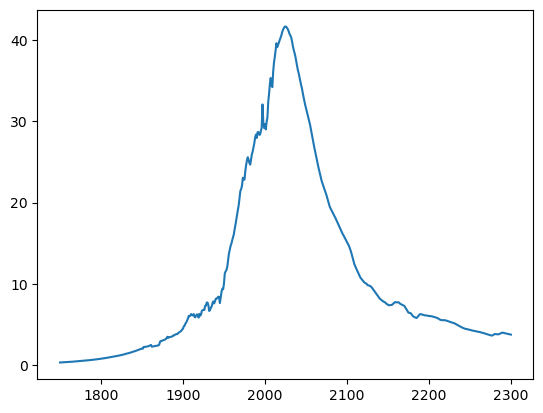

In [12]:
pl.plot(np.arange(1750, 2301), np.median(co2, axis=1))

In [13]:
seed = 1355763 + 399 * np.array(configs)

In [14]:
calibrated_f4co2_mean = df_configs['F_4xCO2'].mean()

In [15]:
fill(f.climate_configs['ocean_heat_capacity'], df_configs.loc[configs, 'c1':'c3'].values)
fill(f.climate_configs['ocean_heat_transfer'], df_configs.loc[configs, 'kappa1':'kappa3'].values)
fill(f.climate_configs['deep_ocean_efficacy'], df_configs.loc[configs, 'epsilon'].values.squeeze())
fill(f.climate_configs['gamma_autocorrelation'], df_configs.loc[configs, 'gamma'].values.squeeze())
fill(f.climate_configs['sigma_eta'], df_configs.loc[configs, 'sigma_eta'].values.squeeze())
fill(f.climate_configs['sigma_xi'], df_configs.loc[configs, 'sigma_xi'].values.squeeze())
fill(f.climate_configs['seed'], seed)
fill(f.climate_configs['stochastic_run'], True)
fill(f.climate_configs['use_seed'], True)
fill(f.climate_configs['forcing_4co2'], 2 * erf_2co2 * (1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[configs,'F_4xCO2'])/calibrated_f4co2_mean))

In [16]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 1001, layer: 3)
Coordinates:
  * config                 (config) int32 2886 4504 6472 ... 1496637 1498879
  * layer                  (layer) int32 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 1.009 2.234 ... 3.088 0.518
    ocean_heat_capacity    (config, layer) float64 5.246 14.51 ... 18.31 46.52
    deep_ocean_efficacy    (config) float64 1.682 1.466 1.744 ... 0.7656 1.046
    stochastic_run         (config) bool True True True True ... True True True
    sigma_eta              (config) float64 0.8411 0.6826 ... 0.2842 0.8318
    sigma_xi               (config) float64 0.2985 0.3713 ... 0.1566 0.3679
    gamma_autocorrelation  (config) float64 8.193 2.073 1.38 ... 6.458 1.09 5.62
    seed                   (config) uint32 2507277 3152859 ... 599408484
    use_seed               (config) bool True True True True ... True True True
    forcing_4co2           (config) float64 8.683 8.136 7.996 ... 7.796 8.169

In [17]:
# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs['iirf_0'], df_configs.loc[configs, 'r0'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_airborne'], df_configs.loc[configs, 'rA'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_uptake'], df_configs.loc[configs, 'rU'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_temperature'], df_configs.loc[configs, 'rT'].values.squeeze(), specie='CO2')

# # aerosol indirect
# fill(f.species_configs['aci_scale'], df_configs.loc[configs, 'beta'].values.squeeze())
# fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_so2'].values.squeeze(), specie='Sulfur')
# fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_bc'].values.squeeze(), specie='BC')
# fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_oc'].values.squeeze(), specie='OC')

# # methane lifetime baseline
# fill(f.species_configs['unperturbed_lifetime'], 10.4198121, specie='CH4')

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people might wanna run pulse expts with these gases)
fill(f.species_configs['baseline_emissions'], 19.019783117809567, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

# # aerosol direct
# for specie in df_ari:
#     fill(f.species_configs['erfari_radiative_efficiency'], df_configs.loc[configs, specie], specie=specie)

# # forcing
# for specie in df_scaling:
#     if specie in ['minorGHG', 'solar_amplitude', 'solar_trend', 'CO2', 'Volcanic']:
#         continue
#     fill(f.species_configs['forcing_scale'], df_configs.loc[configs, specie].values.squeeze(), specie=specie)
# for specie in ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
#     'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
#     'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
#     'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32',
#     'HFC-365mfc', 'HFC-4310mee']:
#     fill(f.species_configs['forcing_scale'], df_configs.loc[configs, 'minorGHG'].values.squeeze(), specie=specie)
fill(f.species_configs['forcing_scale'], 1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[configs,'F_4xCO2'].values)/calibrated_f4co2_mean, specie='CO2')
fill(f.species_configs['forcing_scale'], df_configs.loc[configs, 'scale CH4'].values.squeeze(), specie='CH4')
fill(f.species_configs['forcing_scale'], df_configs.loc[configs, 'scale N2O'].values.squeeze(), specie='N2O')

# # ozone
# for specie in df_ozone:
#     fill(f.species_configs['ozone_radiative_efficiency'], df_configs.loc[configs, specie], specie=specie)

# # tune down volcanic efficacy
# fill(f.species_configs['forcing_efficacy'], 0.6, specie='Volcanic')


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(f.species_configs['baseline_concentration'], df_configs.loc[configs, 'co2_concentration_1750'].values.squeeze(), specie='CO2')

# initial conditions
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [18]:
f.run()

Running 100100 projections in parallel:   0%|          | 0/551 [00:00<?, ?timesteps/s]

In [19]:
# this file is out of date and needs to be remade
df_ssp_median=pd.read_csv('../data_input/ssp_median_temperature.csv', index_col=0)

(2000.0, 2300.0)

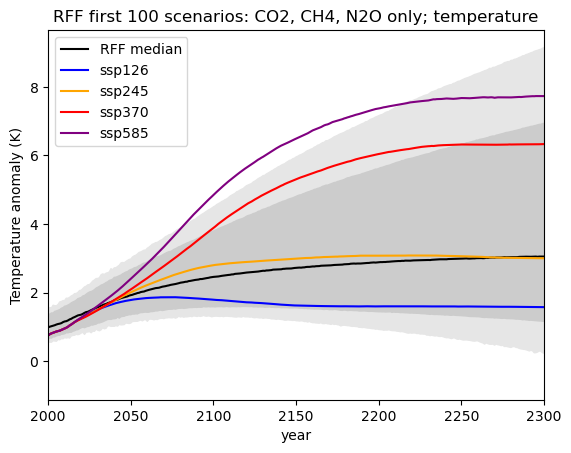

In [20]:
pl.fill_between(
    f.timebounds, 
    np.percentile(f.temperature[...,0] - f.temperature[100:151,...,0].mean(axis=0), 1, axis=(1,2)),
    np.percentile(f.temperature[...,0] - f.temperature[100:151,...,0].mean(axis=0), 99, axis=(1,2)),
    color='0.9'
)
pl.fill_between(
    f.timebounds, 
    np.percentile(f.temperature[...,0] - f.temperature[100:151,...,0].mean(axis=0), 5, axis=(1,2)),
    np.percentile(f.temperature[...,0] - f.temperature[100:151,...,0].mean(axis=0), 95, axis=(1,2)),
    color='0.8'
)
pl.plot(
    f.timebounds, 
    np.percentile(f.temperature[...,0] - f.temperature[100:151,...,0].mean(axis=0), 50, axis=(1,2)),
    color='k',
    label='RFF median'
)
pl.plot(
    np.arange(1750, 2301),
    df_ssp_median['ssp126'],
    color='blue',
    label='ssp126'
)
pl.plot(
    np.arange(1750, 2301),
    df_ssp_median['ssp245'],
    color='orange',
    label='ssp245'
)
pl.plot(
    np.arange(1750, 2301),
    df_ssp_median['ssp370'],
    color='red',
    label='ssp370'
)
pl.plot(
    np.arange(1750, 2301),
    df_ssp_median['ssp585'],
    color='purple',
    label='ssp585'
)

pl.title('RFF first 100 scenarios: CO2, CH4, N2O only; temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
pl.legend(loc='upper left')
pl.xlim(2000, 2300)

(2000.0, 2300.0)

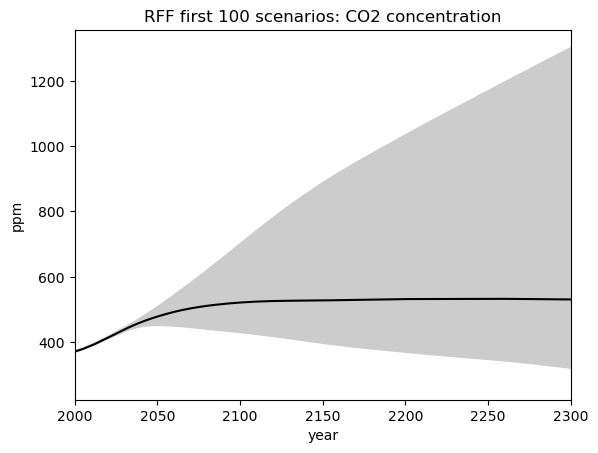

In [21]:
pl.fill_between(
    f.timebounds, 
    np.percentile(f.concentration[...,0], 5, axis=(1,2)),
    np.percentile(f.concentration[...,0], 95, axis=(1,2)),
    color='0.8'
)
pl.plot(
    f.timebounds, 
    np.percentile(f.concentration[...,0], 50, axis=(1,2)),
    color='k'
)
pl.title('RFF first 100 scenarios: CO2 concentration')
pl.xlabel('year')
pl.ylabel('ppm')
pl.xlim(2000, 2300)

(2000.0, 2300.0)

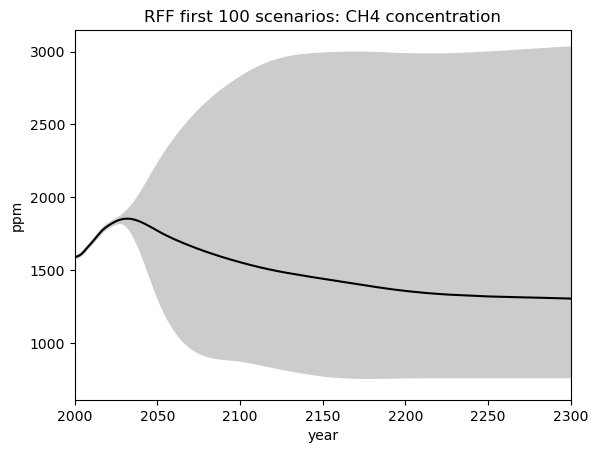

In [22]:
pl.fill_between(
    f.timebounds, 
    np.percentile(f.concentration[...,1], 5, axis=(1,2)),
    np.percentile(f.concentration[...,1], 95, axis=(1,2)),
    color='0.8'
)
pl.plot(
    f.timebounds, 
    np.percentile(f.concentration[...,1], 50, axis=(1,2)),
    color='k'
)
pl.title('RFF first 100 scenarios: CH4 concentration')
pl.xlabel('year')
pl.ylabel('ppm')
pl.xlim(2000, 2300)

(2000.0, 2300.0)

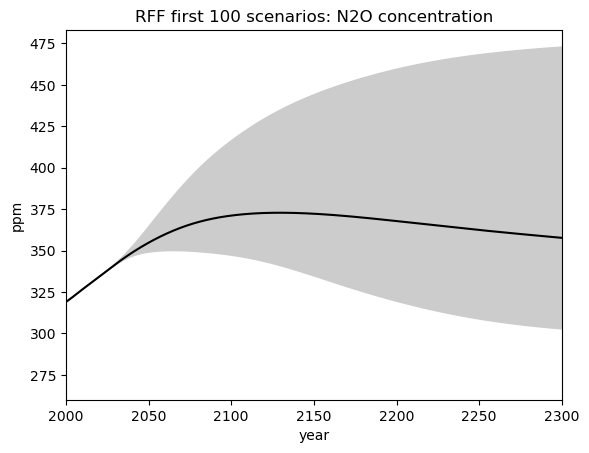

In [23]:
pl.fill_between(
    f.timebounds, 
    np.percentile(f.concentration[...,2], 5, axis=(1,2)),
    np.percentile(f.concentration[...,2], 95, axis=(1,2)),
    color='0.8'
)
pl.plot(
    f.timebounds, 
    np.percentile(f.concentration[...,2], 50, axis=(1,2)),
    color='k'
)
pl.title('RFF first 100 scenarios: N2O concentration')
pl.xlabel('year')
pl.ylabel('ppm')
pl.xlim(2000, 2300)